# Spaceship Titanic

# Introduction

In [14]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [15]:
train = pd.read_csv('../../data/original_data/train.csv')
test = pd.read_csv('../../data/original_data/test.csv')

len_train = len(train)
len_test = len(test)

train.shape, test.shape

((8693, 14), (4277, 13))

## Concatenate Train and Test

- Confirm Shape

In [16]:
df = pd.concat([train, test])

df.shape[0] == test.shape[0] + train.shape[0]

True

# Descriptive Analysis

- What it is asking for

# Data Analysis

## Target Variable - Trasported

- Bar chart with numbers

In [17]:
df.Transported.value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

/tmp/ipykernel_76927/236666540.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered_df, x='Transported', palette='pastel')


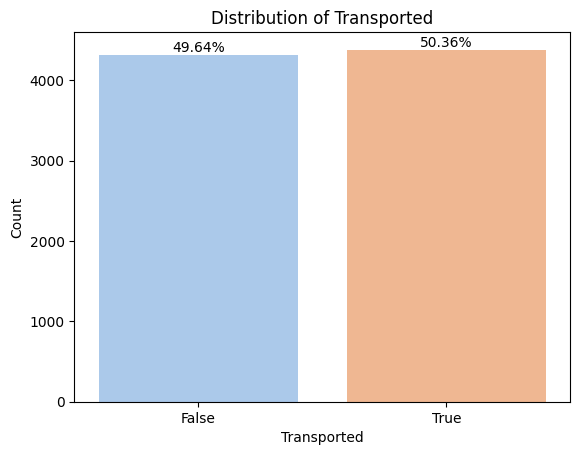

In [24]:
# Filter out null values
filtered_df = df.dropna(subset=['Transported'])

# Create a count plot with customized colors
ax = sns.countplot(data=filtered_df, x='Transported', palette='pastel')

# Add labels and title
plt.xlabel('Transported')
plt.ylabel('Count')
plt.title('Distribution of Transported')

# Calculate the total number of non-null entries
total = len(filtered_df)

# Annotate the bars with the percentage
for p in ax.patches:
    height = p.get_height()
    percentage = f'{height / total * 100:.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

The target variable **Transported** is almost perfectly balanced, so there is no need to focus on this.

## Distribution

### Categorical Variables

- HomePlanet
- CryoSleep
- Destination
- VIP

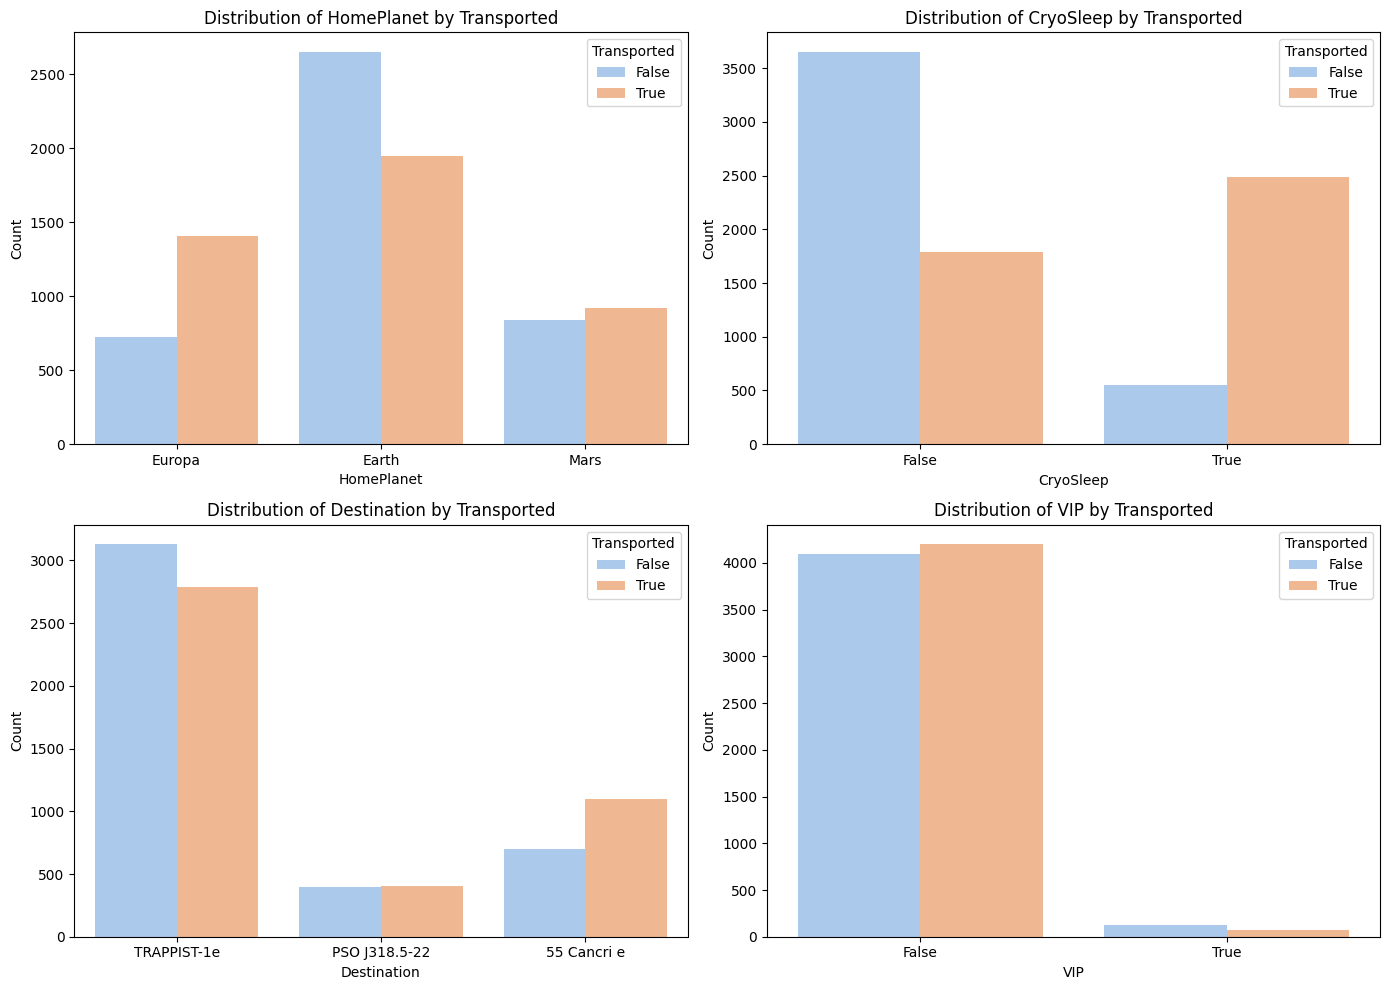

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out null values from 'Transported'
filtered_df = df.dropna(subset=['Transported'])

# Define the categorical variables to plot
categorical_vars = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Create a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each categorical variable split by 'Transported'
for i, var in enumerate(categorical_vars):
    sns.countplot(data=filtered_df, x=var, hue='Transported', palette='pastel', ax=axes[i])
    axes[i].set_title(f'Distribution of {var} by Transported')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


**NB**
- HomePlanet: While Europa and Earth seem to be more significant, Mars does not appear to be.
- CryoSleep: Looks like a significant feature.
- Destination: PSO J318.5-22 looks to be insignificant.
- VIP: Doesn't look like it will give us much

### Numerical Variables

- Age
- RoomService
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

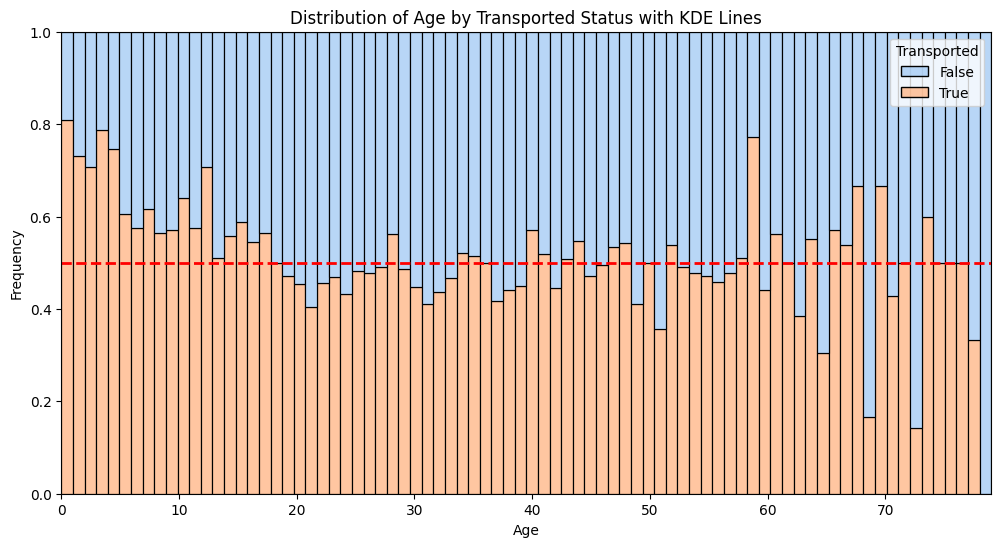

In [62]:
# Filter out null values from 'Age' and 'Transported'
df_clean = df.dropna(subset=['Age', 'Transported'])

# Create the histogram plot with KDE lines
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='Age', hue='Transported', multiple='fill', palette='pastel', bins=80)

# Add a vertical red line at x = 0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Distribution of Age by Transported Status with KDE Lines')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Display the plot
plt.show()

We can see that those passengers aged 18 and under are more likely to be trasnported, with some other smaller age groups less likely to be transported.

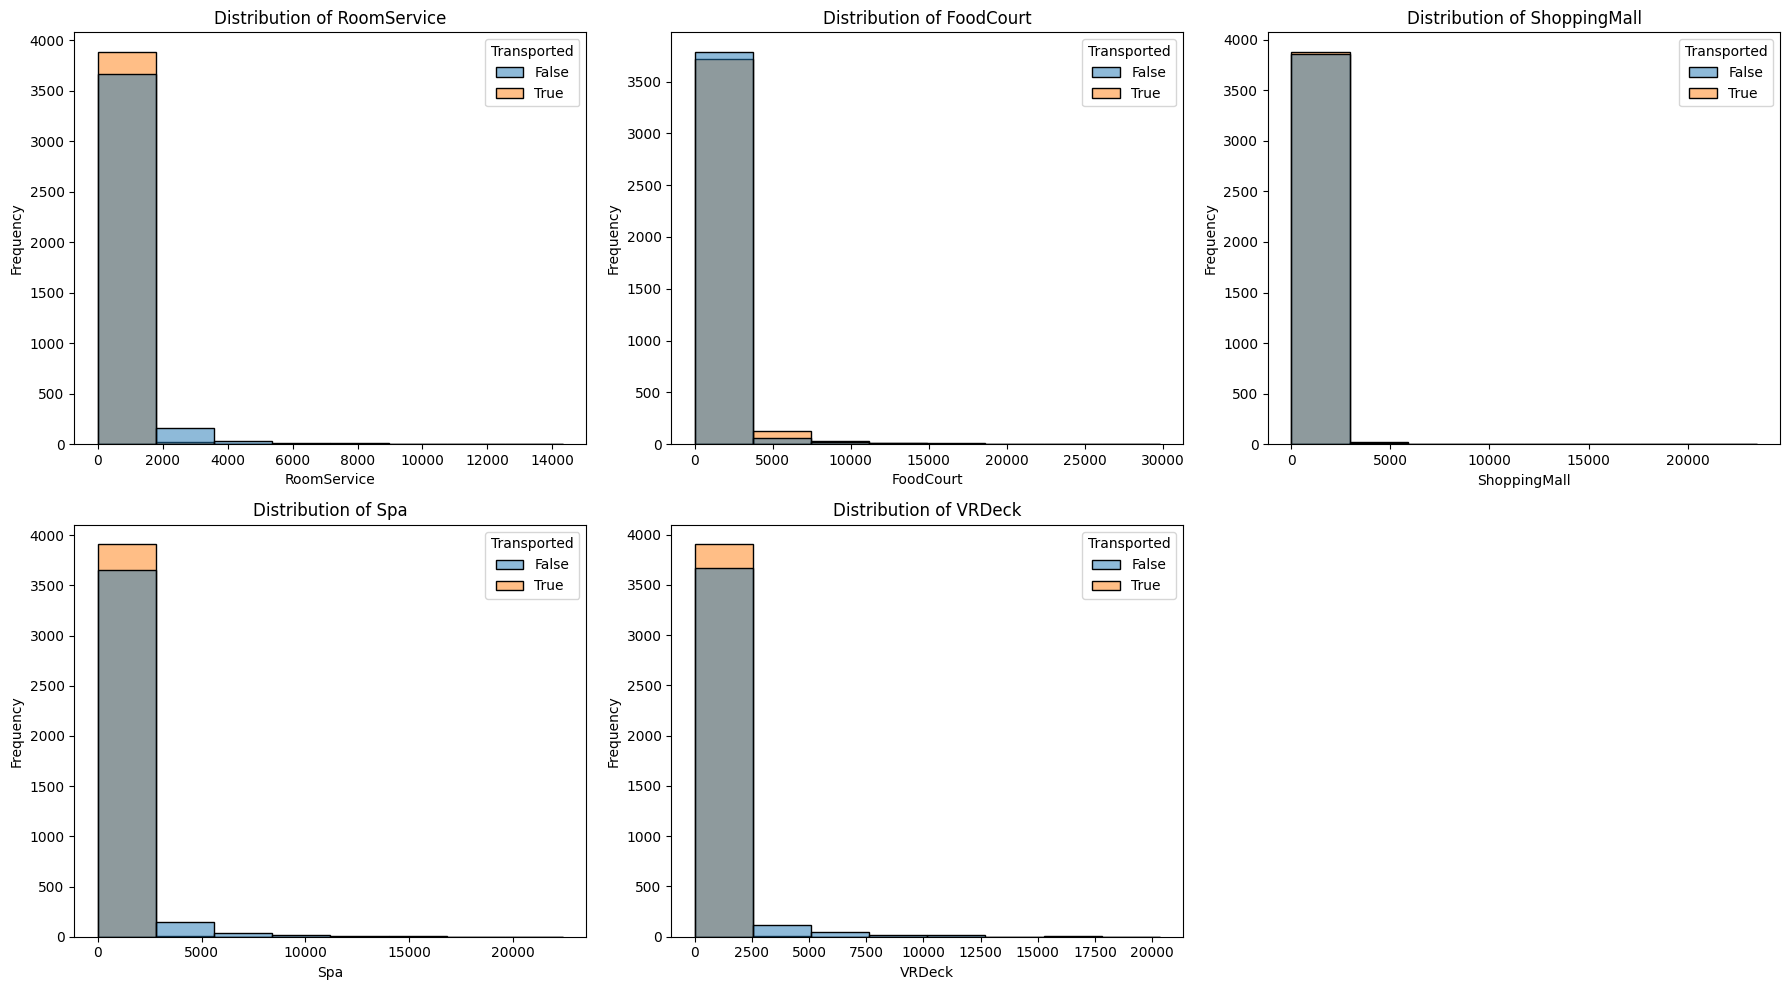

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the spending variables
spending_vars = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Filter out rows with null values in any of the spending columns
df_clean = df.dropna(subset=spending_vars)

# Create a subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot histograms for each spending variable
for i, var in enumerate(spending_vars):
    sns.histplot(data=df_clean, x=var, hue='Transported', kde=False, ax=axes[i], color='skyblue', bins=8)
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

# Remove the empty subplot (if any)
if len(spending_vars) < len(axes):
    fig.delaxes(axes[len(spending_vars)])

# Adjust layout
plt.tight_layout()
plt.show()


We can see from the protruding blue in higher spends on RoomService, Spa, and VRDeck that higher spends shows some correlation to not being transported, and the opposite is true for the FoodCourt.

The expenditures will have to be scaled in some way to account for the skewed distribution

 # Feature Engineering

Regarding PassengerId, we are told:

**PassengerId** - *A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.* **People in a group are often family members, but not always.**

As a result I decided to create the new columns PassengerGroup and SoloPassenger, working on the assumption that they are often family members

In [68]:
# Create Passenger Group from gggg of PassengerId
df['PassengerGroup'] = df['PassengerId'].apply(lambda x: x.split('_')[0])

# Take Group size by number of passengers in group
group_size = df.groupby('PassengerGroup').size().reset_index(name='GroupSize')
df = df.merge(group_size, on='PassengerGroup')

# Determine if the passenger is riding solo
df['SoloPassenger'] = df['GroupSize'].apply(lambda x: 1 if x == 1 else 0)

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,GroupSize,SoloPassenger
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,1
